# RNN-based Solution

The introduction of this file is courtesy of the team at Perceptive Automata

### Imports

In [1]:
import ast
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Bidirectional, BatchNormalization, LSTM, Dense


from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# Older version of sklearn
#from sklearn.cross_validation import train_test_split

# Newer versions of sklearn
from sklearn.model_selection import train_test_split

# Pedestrian Crossing Prediction

This problem uses the opensource JAAD dataset for this problem, which you can read more about here: http://data.nvision2.eecs.yorku.ca/JAAD_dataset/. The data is available in this library as "pedestrians_df.csv".

The dataset consists of tracked people in some videos from a car's dashcam.  Each of these people have been carefully annotated with a bunch of different attributes, such as whether or not they are stopped or moving fast or moving slow.  For this problem we will try to predict whether or not the pedestrian will cross the street in the next frame based on all previous data we have about the pedestrian.  You will use the bounding boxes of the pedestrians along with the other actions that they take to try to predict this for a test set.

## Dataframe

Each row of the dataframe that we construct for you consists of some meta data about the video id and the ped id so that you can match them up with the JAAD videos, and then an ordered list of frames where that pedestrian appears.  

* frame_numbers - These should be continuous and there should be no gaps in these lists.  The other fields all align with the frame number field.
* bounding_boxes - This field is a series of boxes that aligns with the frame_numbers field.  Each box is constructed of [box x, box y, box width, box height], where x and y represent the upper left hand corner of the box
* moving_slow, stopped, handwave, look, clear path, moving fast, looking, standing, slow down, nod, speed up - The annotated attributes you will use to train the model, each is a list that aligns with the frame_numbers field of whether or not the attribute is true for that frame number
* crossing - Whether or not the pedestrian is crossing for this corresponding frame number 
* cross_overall - This is the field that you will try to predict, it is whether or the person crossed at any point in the sequence

In [ ]:
pedestrians_df = pd.read_csv('data/pedestrian_df.csv')
for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
    pedestrians_df[col_name] = pedestrians_df[col_name].apply(ast.literal_eval)
pedestrians_df.head()

In [7]:
count = 0
for i, row in pedestrians_df.iterrows():
    count += len(row['frame_numbers'])
    
print("Number of Pedestrian-Frames: %d" % count)

Number of Pedestrian-Frames: 128220


In [8]:
# Let's take a more in-depth look at that first row:
print(pedestrians_df.iloc[5])
print(pedestrians_df.iloc[5]['frame_numbers'])

video_id                                                 video_0204
ped_ind                                                           5
frame_numbers     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
bounding_boxes    [[868, 664, 34, 70], [870, 666, 33, 70], [872,...
moving slow       [False, False, False, False, False, False, Fal...
stopped           [False, False, False, False, False, False, Fal...
handwave          [False, False, False, False, False, False, Fal...
look              [False, False, False, False, False, False, Fal...
clear path        [False, False, False, False, False, False, Fal...
crossing          [True, True, True, True, True, True, True, Tru...
moving fast       [False, False, False, False, False, False, Fal...
looking           [False, False, False, False, False, False, Fal...
standing          [False, False, False, False, False, False, Fal...
slow down         [False, False, False, False, False, False, Fal...
nod               [False, False, False, False, F

# More info

Your task is predict, for each pedestrian, whether or not they will be crossing the road at each frame.  For example, for row 0 of the above dataframe, the pedestrian appears in frames 0-329.  For each of those frames, you need to predict whether or not they will be crossing or not crossing in the next frame.  So, for frame number 5, you can use whatever data you want from frames 0-4 to predict whether or not they will be crossing in frame 5.  And for frame 329, you can use whatever data you want from frames 0-328 to predict whether or not they will be crossing.

You can skip the first few frames for each pedestrian if your solution requires a certain number of frames to be initialized.

You will need to:
- unravel the existing per-pedestrian dataframe to build your new per-pedestrian-frame dataframe.  
- extract features
- split the data into train and validation sets (70%-30% split is probably about the right size)
- build a baseline that simply predicts the previous frames' "crossing" value for the next frame
- make some models
- test your final model on your validation set
- write up your analysis

In [7]:

### YOUR CODE HERE ###

#Padding function for wrangling
class TooLongError(ValueError):
    pass

def pad(seq, target_length, padding=None):
    """Extend the sequence seq with padding (default: None) so as to make
    its length up to target_length. Return seq. If seq is already
    longer than target_length, raise TooLongError.
    
    This function was borrowed from a github forum
    
    >>> pad([], 5, 1)
    [1, 1, 1, 1, 1]
    >>> pad([1, 2, 3], 7)
    [1, 2, 3, None, None, None, None]
    >>> pad([1, 2, 3], 2)
    ... # doctest: +IGNORE_EXCEPTION_DETAIL
    Traceback (most recent call last):
      ...
    TooLongError: sequence too long (3) for target length 2

    """
    
    
    length = len(seq)
    if length > target_length:
        raise TooLongError("sequence too long ({}) for target length {}"
                           .format(length, target_length))

    seq.extend([padding] * (target_length - length))
    return seq

#PREPARE NEW DATASET
'''
PREPARE THE NEW DATASET

Here I take the imported original dataframe. I have decided to structure 
my supervised learning set in the Keras form: [Customer, frame, feature]

This dataset includes the supervised learning outcomes. We have both, the 
crossing feature for each time, and the crossed feature. The crossing attribute
is offset so that at a time t, the crossing attribute assigned to the time is
the crossing attribute at time t+1. 

Since I had to normalize the size of the dataset (not all pedestrians were in
the video for the same number of frames), the positions that had no data were
given the -1 value. The neural network will learn that -1 has no importance.

The resulting array is stored in new_ped_data.pkl
'''
def Wrangle_Data():
    pedestrians_df = pd.read_csv('../data/pedestrian_df.csv')
    for col_name in ['bounding_boxes', 'frame_numbers', 'moving slow', 'stopped', 'handwave', 'look', 'clear path', 'crossing', 'moving fast', 'looking', 'standing', 'slow down', 'nod', 'speed up']:
        pedestrians_df[col_name] = pedestrians_df[col_name].apply(ast.literal_eval)

    n_pedestrians = len(pedestrians_df['video_id'])
    max_frames = max(len(ped) for ped in pedestrians_df['frame_numbers'])
    n_inputs = 4 + 12 + 1    #Box bounds, attributes, crossing classification
    new_ped_data = np.zeros((n_pedestrians,max_frames,n_inputs-2))
    new_ped_valid_data = np.zeros((n_pedestrians,max_frames,2))
    new_ped_valid_data2 = np.zeros((n_pedestrians,max_frames,1))    #Validation set with t+1 observation
    copy_pedestrians_df = pd.DataFrame.copy(pedestrians_df)
    
    attribute_list = ['bounding_boxes','moving slow','stopped','handwave','look',
                      'clear path','moving fast','looking','standing', 'slow down', 
                      'nod','speed up','crossing',]
    
    
    i = 0
    #Pad all attributes missing data
    while i < n_pedestrians:
        for attribute in attribute_list:
            pad(copy_pedestrians_df[attribute][i],max_frames,padding=-1)
        i += 1
    
    #Manipulate special case of bounding_boxes since they have 4 values
    for i in range(n_pedestrians):
        for j in range(len(copy_pedestrians_df['bounding_boxes'][i])):
            box_vals = copy_pedestrians_df['bounding_boxes'][i][j]
            if box_vals == -1:
                box_vals = 4*[-1]
            for k in range(len(box_vals)):
                new_ped_data[i][j][k] = box_vals[k]
    print('Bounding boxes done')            
    
    #Copy training data into the data array
    for k in range(4,n_inputs-2):
        attribute = attribute_list[k-3]
        for i in range(n_pedestrians):
            attribute_array = np.asarray(copy_pedestrians_df[attribute][i]).astype  (int)
            for j in range(max_frames):
                new_ped_data[i][j][k] = attribute_array[j]
    
     #Copy validation data into the two data arrays
    for i in range(n_pedestrians):
        attribute_array = np.asarray(copy_pedestrians_df['crossing'][i]).astype(    int)
        crossed = 0
        for j in range(max_frames):
            if (j+1 == max_frames):
                next_ind_value = -1
            else:
                next_ind_value = attribute_array[j+1]
            
            if (attribute_array[j] == -1):
                crossed = -1        
            elif next_ind_value == 1 or crossed == 1:
                crossed = 1
                
            new_ped_valid_data[i][j][0] = next_ind_value
            new_ped_valid_data[i][j][1] = crossed
            
            new_ped_valid_data2[i][j][0] = next_ind_value
    #SAVE ARRAY WITH PICKLE
    pickle.dump(new_ped_data, open('../data/new_ped_data.pkl','wb'))
    pickle.dump(new_ped_valid_data, open('../data/new_ped_valid_data.pkl','wb'))    
    pickle.dump(new_ped_valid_data2, open('../data/new_ped_valid_data2.pkl','wb'))
    
    print('Yeehaw, finished!')
 

######
#Wrangle Data- uncomment to rewrangle data. Example of data is given below this cell
# Wrangle_Data()

#Load new data array

new_ped_data = pickle.load(open('../data/new_ped_data.pkl','rb'))
new_ped_valid_data = pickle.load(open('../data/new_ped_valid_data.pkl','rb'))
new_ped_valid_data2 = pickle.load(open('../data/new_ped_valid_data2.pkl','rb')) #This is the set with 1 classification for each tstep
######
#Model Evaluation

def RunRNN(X_data, Y_data, batch_n, n_epochs, h1, h2):
    '''
    Runs the RNN and returns the data for the model's fit for the main data: new_ped_valid_data2
    
    X_data: Training features
    Y_data: Classifications/validation data
    batch_n: Number of batches
    n_epochs: Number of epochs 
    h1: Hidden layer 1 size 
    h2: Hidden layer 2 size
    '''
    
    
    Train_X = X_data[0:466]
    Test_X = X_data[466:]

    Train_Y = Y_data[0:466]
    Test_Y = Y_data[466:]

    model = Sequential()
    model.add(Bidirectional(LSTM(h1, return_sequences=True),
                            input_shape=Train_X.shape[1:]))
    model.add(Bidirectional(LSTM(h2, return_sequences=True)))
#    model.add(Bidirectional(LSTM(10, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mae', 
                  optimizer='rmsprop')

    history = model.fit(Train_X, Train_Y, epochs = n_epochs, batch_size = batch_n, 
                        validation_data =(Test_X, Test_Y), verbose=0)
    return history

def RunRNN_one_hidden(X_data, Y_data, batch_n, n_epochs, h1):
    '''
    Runs the RNN and returns the data for the model's fit for the data: new_ped_valid_data
    
    X_data: Training features
    Y_data: Classifications/validation data
    batch_n: Number of batches
    n_epochs: Number of epochs 
    h1: Hidden layer 1 size 
    '''
    Train_X = X_data[0:466]
    Test_X = X_data[466:]

    Train_Y = Y_data[0:466]
    Test_Y = Y_data[466:]

    model = Sequential()
    model.add(Bidirectional(LSTM(h1, return_sequences=True),
                            input_shape=Train_X.shape[1:]))
    model.add(Dense(1))
    model.compile(loss='mae', 
                  optimizer='rmsprop')

    history = model.fit(Train_X, Train_Y, epochs = n_epochs, batch_size = batch_n, 
                        validation_data =(Test_X, Test_Y), verbose=0)
    return history


# Data format

In [3]:
print('Training data')
print(new_ped_data[0][327:332])

print('Validation data')
print(new_ped_valid_data[0][327:332])

print('Validation data, crossing only')
print(new_ped_valid_data2[0][327:332])

Training data
[[  1.79626198e+03   5.15113749e+02   9.18489350e+01   3.42694413e+02
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.79859340e+03   5.16832761e+02   9.41189230e+01   3.42062119e+02
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.80100000e+03   5.19184211e+02   9.73947370e+01   3.41815789e+02
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.00000000e+00  -1.00000000e+00  -1.00000000e+00  -1.00000000e+00
   -1.00000000e+00  -1.00000000e+00  -1.00000000e+00  -1.00000000e+00
   -1.00000000e+00  -1.00000000e+00  -1.00000000e+00  

# Example Model & Results

Use this model if you want to test how my network runs. Also, make the change ```verbose = 1``` to line 149 in ```RunRNN()``` if you want the epoch data printed.

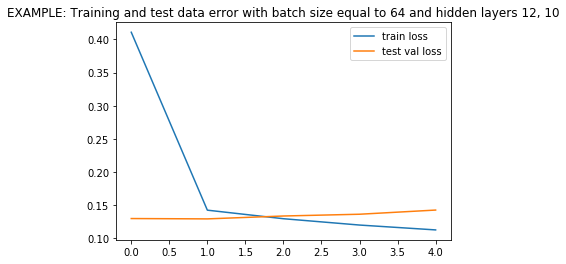

In [5]:
#Change verbose to 1 in RunRNN() function to view training progress

n_epochs = 5
batch_size = 64
hidden1_layer = 12
hidden2_layer = 10

history = RunRNN(new_ped_data, new_ped_valid_data2, batch_size, n_epochs, hidden1_layer,hidden2_layer)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('EXAMPLE: Training and test data error with batch size equal to '+ 
                str(batch_size)+ ' and hidden layers '+str(hidden1_layer)+', '+str(hidden2_layer))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

# Different Models & Results

The results below can all be run. Some of them might take some time because multiple trials are run or the number of epochs is large. 

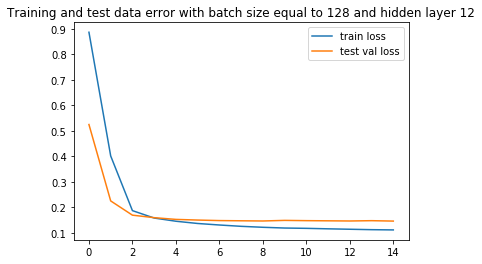

In [48]:
loss_data = []
v_loss_data = []
for i in range(5):
    one_h_layer = RunRNN_one_hidden(new_ped_data, new_ped_valid_data2, 128, 15, 12)
    loss_data.append(one_h_layer.history['loss'])
    v_loss_data.append(one_h_layer.history['val_loss'])
model_loss = np.mean(loss_data,axis=0)
val_model_loss = np.mean(v_loss_data,axis=0)

pyplot.plot(model_loss, label='train loss')
pyplot.plot(val_model_loss, label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(128)+ ' and hidden layer '+str(12))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

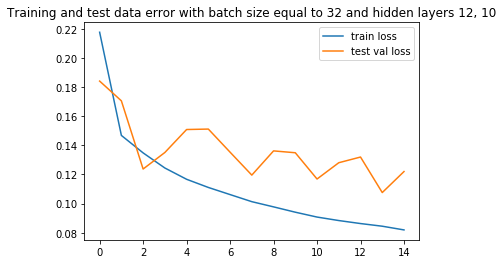

In [49]:
history = RunRNN(new_ped_data, new_ped_valid_data2, 32, 15, 12, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(32)+ ' and hidden layers '+str(12)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

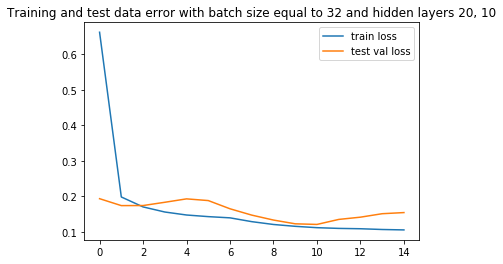

In [50]:
history = RunRNN(new_ped_data, new_ped_valid_data2, 128, 15, 20, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(32)+ ' and hidden layers '+str(20)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

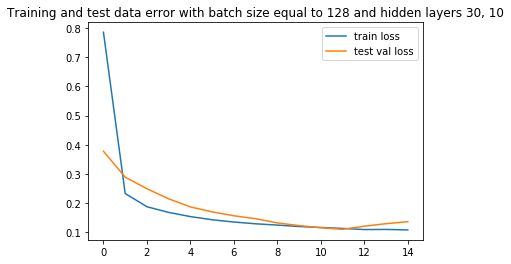

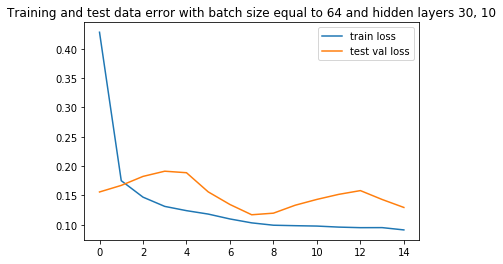

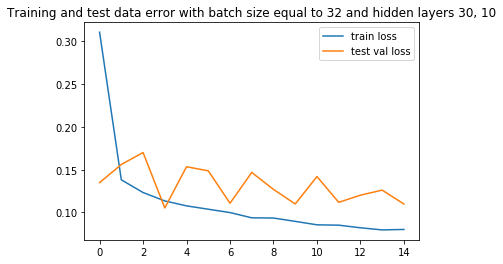

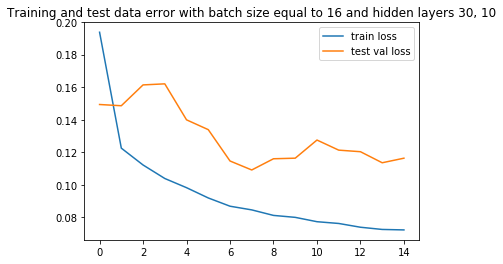

In [51]:
history = RunRNN(new_ped_data, new_ped_valid_data2, 128, 15, 30, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(128)+ ' and hidden layers '+str(30)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

pyplot.figure()
history = RunRNN(new_ped_data, new_ped_valid_data2, 64, 15, 30, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(64)+ ' and hidden layers '+str(30)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

pyplot.figure()
history = RunRNN(new_ped_data, new_ped_valid_data2, 32, 15, 30, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(32)+ ' and hidden layers '+str(30)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

pyplot.figure()
history = RunRNN(new_ped_data, new_ped_valid_data2, 16, 15, 30, 10)
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(16)+ ' and hidden layers '+str(30)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

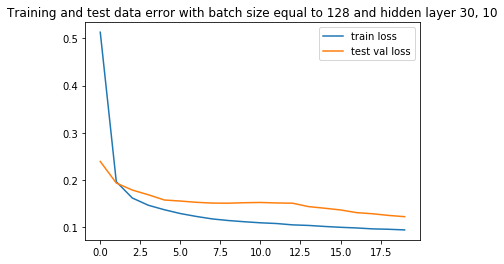

In [47]:
loss_data = []
v_loss_data = []
for i in range(5):
    print('Currently on trial '+str(i))
    model_data = RunRNN(new_ped_data, new_ped_valid_data2, 128, 15, 30, 10)
    loss_data.append(model_data.history['loss'])
    v_loss_data.append(model_data.history['val_loss'])
model_loss = np.mean(loss_data,axis=0)
val_model_loss = np.mean(v_loss_data,axis=0)
pyplot.plot(model_loss, label='train loss')
pyplot.plot(val_model_loss, label='test val loss')
# pyplot.plot(one_h_layer.history['loss'], label='train loss')
# pyplot.plot(one_h_layer.history['val_loss'], label='test val loss')
title_str = ('Training and test data error with batch size equal to '+ 
                str(128)+ ' and hidden layers '+str(30)+', '+str(10))
pyplot.title(title_str)
pyplot.legend()
pyplot.show()

## Analysis


This problem was tricky for several reasons. It was my first time working with temporal data, and as such my first time using Keras and a recurrent neural network. Initially I was planning on using scikit-learn and the random forest classifier because it was given as an initial import, but I have not used random forests before and could not find documentation that would help me with the temporal data. Thus I decided to use a recurrent neural network and Keras because the RNN is able to work with temporal data and consider the previous time step(s) and its(their) results. I also decided to do the RNN because it was stated that this problem is more open ended.

With the RNN I was able to wrangle the given data into an easily usable state. As I stated in the code in the comment for the data structuring, I transformed the data into a 3D numpy array structured like: [Customer, timesteps, features]. This is the format that Keras and the RNN takes as an input. To do this I had to normalize the inputs so that the same size array is input for each customer. For cases with less than the maximum number of frames, I padded the extra spaces with the value -1. The bounding box features had the frame values, and the remaining features used binary representations for the True and False values. From here, I extract the data for the supervised learning problem.

Initially I was not sure if I should use only the crossing feature as part of the classification, or if I should include the crossing feature as well as the crossed overall feature. For the data named *new_ped_valid_data* I included both features. I shifted the classification for crossing down an index number so that the classification would be predicting whether the next frame would be crossing or not. 

EX: Originally Frames[0,1,2] have Classification [0,1,1]
But now they have Classification [1,1,-1]

I also structured the crossed with whether or not there has been a crossing at any point. If there has been a crossing at the given time step or any time step in the past the feature is tagged as 1. If the index is past the number of frames in the given set then the remaining positions are tagged as -1. After trying this method out I concluded that it might not be doing exactly as I wished so then I made the dataset *new_ped_valid_data2* which only contains the crossing classification value at each time step.

I have tried many different structures and some of the better ones have been given above. I see that batch size has a significant impact on the training, as well as the hidden network architecture. So far I found that a single hidden layer with a hidden layer of 12 and batch size of 128 has some of the best results along with a network with two hidden layers, 30, 10 respectively, and a batch size of 128. These have resulted in some of the best results that have been averaged over multiple trials. In other cases the model gets to around the same error in a few epochs, but then is overfit. These cases tend to have results that continue decreasing. My best error is between 10% and 15%, which is relatively high, but better than what I was expecting to obtain.

Overall I learned  quite a bit during this exercise, and am curious to dive a little deeper into optimization and fine tuning of the model. One thing that I might need to consider next time is whether normalizing the inputs for the bounding boxes is necessary. I couldn't find information on the JAAD source page or in the README if different video formats/resolutions were used. So I'm assuming since the README says that the dataset uses "High resolution videos", that I do not need to normalize the bounding boxes because they are the same resolution. 
